# Pré-traitement des données et apprentissage de la position sur les colonnes titre et description (sans doublons)

## Modules à importer

In [1]:
import pandas as pd
import nltk
import string
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import FrenchStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

## Lecture du fichier CSV et création de la dataframe

In [2]:
opinion_df = pd.read_csv ("./data_website_tab.csv", sep="\t", names=["titre", "description","position","theme"],dtype={"titre":"object","description":"object","position":"category","theme":"category"},header=None)

## Suppression des lignes vides

In [3]:
opinion_df_clean = opinion_df.dropna(how='any')

## Récupération des index des lignes sans texte ne contenant que des espaces 

In [4]:
opinion_df_spaces = opinion_df_clean[(opinion_df_clean.description == " ") |(opinion_df_clean.description == "  ")]

## Suppression des lignes ayant uniquement des espaces

In [5]:
opinion_df_clean2 = opinion_df_clean.drop(index=opinion_df_spaces.index)

## Remplacement du jeu de données initial par le jeu de données nettoyé

In [6]:
opinion_df= opinion_df_clean2


# Suppression des doublons


## Nombre de lignes pour chaque position avant suppression des doublons 

In [7]:
opinion_df.position.value_counts()

Agit pour les animaux        3899
Agit contre les animaux      2768
Penche pour les animaux       565
Penche contre les animaux     326
Name: position, dtype: int64

# Observations
_doublons lignes d'index 4 et 5 ; 20, 21, 22, et 23 ; 24, 25, 26 et 27_

In [8]:
 opinion_df.head(30)

,titre,description,position,theme
0,Le député Loïc Dombreval demande au gouverneme...,.@LoicDombreval se prononce pour une anticipa...,Agit pour les animaux,elevage
1,Ces maires ont attribué une délégation conditi...,Ces maires ont attribué à un conseiller ou un...,Agit pour les animaux,droit-animal
2,Tribune en faveur de la censure du débat publi...,"Soutien assumé à la convention « Déméter », d...",Agit contre les animaux,elevage
3,Proposition de loi n°1896 visant à abolir l’él...,"En France, il est interdit de fabriquer et ve...",Agit pour les animaux,elevage
4,3 Députés demandent au gouvernement d'intégrer...,Question écrite de M. Dimitri Houbron député ...,Agit pour les animaux,mer-pisciculture
5,3 Députés demandent au gouvernement d'intégrer...,Question écrite de M. Dimitri Houbron député ...,Agit pour les animaux,elevage
6,Le sénateur Arnaud Bazin demande des explicati...,Question écrite n° 18999 de M. Arnaud Bazin ...,Agit pour les animaux,experimentation-animale
7,La ville de Montpellier vote un vœu visant à i...,Le Conseil municipal de la ville de Montpelli...,Agit pour les animaux,zoo-cirque
8,"Éric Piolle, maire de Grenoble, soutient le Ré...",Dans une vidéo publiée sur le compte Twitter ...,Agit pour les animaux,droit-animal
9,"Anne Hidalgo, maire de Paris, et Christophe Na...",À l'occasion de la journée mondiale des anima...,Agit pour les animaux,droit-animal


## Suppression des doublons de colonnes titre et description 

In [9]:
opinion_df_clean3 = opinion_df.drop_duplicates(subset=['titre', 'description'])

In [10]:
 opinion_df_clean3.position.value_counts()

Agit pour les animaux        3399
Agit contre les animaux      2511
Penche pour les animaux       523
Penche contre les animaux     290
Name: position, dtype: int64

## Remplacement des index manquants (supprimés avec drop_duplicates) par de nouveaux index réordonnés

In [11]:
 opinion_df_clean3 = opinion_df_clean3.reset_index(drop=True)

## Remplacement le jeu de données initial par le jeu de données nettoyé

In [12]:
opinion_df = opinion_df_clean3

## Extraction pour position

In [ ]:
X = opinion_df[["titre", "description"]]
y = opinion_df.position

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Créations des différentes fonctions utilisées

In [ ]:
class SingleColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, data_dict):
        return data_dict[self.key]
    
class MultiColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns].to_dict('records')
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)

In [ ]:
def split_into_tokens_nltk(desc) :
    return word_tokenize(desc)

In [ ]:
fs = FrenchStemmer()
def split_into_stems(desc):
    words = word_tokenize(desc)
    return [fs.stem(w) for w in words]

## Liste des nombres et lois + signes de ponctuation

In [ ]:
stopwords = open('stopwords_list.txt','r').read().split()
nblaw_stopwords = stopwords+list(string.punctuation)

## Pipeline pour la colonne titre et transformation du texte en sac de mots avec CountVectorizer + application du pipeline sur X_train

In [22]:
titre_vectorizer = CountVectorizer(tokenizer=split_into_stems, lowercase=True, stop_words=nblaw_stopwords, min_df=0.01)
    
titre_pipeline = make_pipeline(
    SingleColumnSelector(key="titre"),
    titre_vectorizer
)

titre_pipeline.fit(X_train)

Pipeline(memory=None,
         steps=[('singlecolumnselector', SingleColumnSelector(key='titre')),
                ('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=0.01,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=['00001002', '0...
                                             '02070', '02302', '03041', '03242',
                                             '03633', '04654', '0507S', '0529G',
                                             '05860', '06227', '0635S', '06657',
                                             '06942', '0714G', '07714', '07795',
                                             '08060', '08152', 

## Affichage des traits

In [26]:
res = titre_pipeline.transform(X_test.head())
print("Input titre")
print(X_test.titre.head())
print("Output bags of words")

bow = pd.DataFrame(res.toarray(), columns=titre_vectorizer.get_feature_names())
bow.set_index(X_test.head().index, inplace=True)
bow.replace(0, np.nan).dropna(axis=1, how='all').fillna(0)

Input titre
3366    Francis Hillmeyer propose de désigner au sein ...
5516    Les élus EELV du Conseil Régional Midi-Pyrénée...
5004    Geneviève Gaillard demande le renforcement des...
2630    Arnaud Viala demande de classer les cormorans ...
2258    Jean-Luc Mélenchon veut fortement encourager l...
Name: titre, dtype: object

Output bags of words


,...,animal,au,aux,comm,conseil,corrid,dan,de,demand,...,régional,subvent,sur,un,veut,vis,«,»,à,élus
3366,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
5516,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2630,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2258,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


## Pipeline pour la colonne description et transformation du texte en vecteurs avec TfidfVectorizer + application du pipeline sur X_train

In [27]:
desc_vectorizer = TfidfVectorizer(tokenizer=split_into_stems,lowercase=True,min_df=0.01)

description_pipeline = make_pipeline(
    SingleColumnSelector(key="description"),
    desc_vectorizer
)

description_pipeline.fit(X_train)

Pipeline(memory=None,
         steps=[('singlecolumnselector',
                 SingleColumnSelector(key='description')),
                ('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=0.01, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function split_into_stems at 0x0000018A8279BC18>,
                                 use_idf=True, vocabulary=None))],
         ver

## Affichage des traits

In [28]:
res = description_pipeline.transform(X_test.head())
print("Input descriptions")
print(X_test.description.head())
print("Output bags of words")

bow = pd.DataFrame(res.toarray(), columns=desc_vectorizer.get_feature_names())
bow.set_index(X_test.head().index, inplace=True)
bow.replace(0, np.nan).dropna(axis=1, how='all').fillna(0)

Input descriptions
3366     De nombreuses études ayant mis en évidence le...
5516     Les élu-es EELV au Conseil Régional dénoncent...
5004     L'outarde canepetière est une espèce protégée...
2630     Pour la pisciculture, ces attaques constituen...
2258     Dans le cadre global de la planification écol...
Name: description, dtype: object

Output bags of words


,',(,),",",-,.,...,100,8,:,...,élevag,état,étud,été,évident,être,œuvr,–,’,€
3366,0.000000,0.016577,0.016583,0.073182,0.084022,0.044221,0.000000,0.000000,0.000000,0.018711,...,0.000000,0.000000,0.106558,0.000000,0.122377,0.060359,0.000000,0.000000,0.000000,0.000000
5516,0.000000,0.000000,0.000000,0.099143,0.000000,0.112328,0.000000,0.000000,0.000000,0.015842,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.385394,0.171143,0.000000
5004,0.000000,0.000000,0.000000,0.194007,0.000000,0.143968,0.021666,0.000000,0.000000,0.013053,...,0.025992,0.000000,0.000000,0.022821,0.085374,0.000000,0.103298,0.000000,0.000000,0.000000
2630,0.027615,0.042203,0.042219,0.372632,0.000000,0.178258,0.039534,0.000000,0.000000,0.011909,...,0.047428,0.026478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2258,0.000000,0.090858,0.090892,0.000000,0.000000,0.080792,0.000000,0.169248,0.147904,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.061548,0.172828


## Fonctions pour obtenir les statistiques textuelles

In [29]:
class TextStats(BaseEstimator, TransformerMixin):

    def fit(self, x, y=None):
        return self

    def transform(self, descs):
        return [{'stats_length': len(text),
                 'stats_num_sentences': text.count('.')+text.count('!')+text.count('?')}
                for text in descs]
    
stats_vectorizer = DictVectorizer()

stats_pipeline = make_pipeline(
    SingleColumnSelector(key="description"),
    TextStats(),
    stats_vectorizer
)

stats_pipeline.fit(X_train)

Pipeline(memory=None,
         steps=[('singlecolumnselector',
                 SingleColumnSelector(key='description')),
                ('textstats', TextStats()),
                ('dictvectorizer',
                 DictVectorizer(dtype=<class 'numpy.float64'>, separator='=',
                                sort=True, sparse=True))],
         verbose=False)

## Application du pipeline sur les 5 premières instances de X_test

In [30]:
res = stats_pipeline.transform(X_test.head())
print("Input")
print(X_test.description.head())
print("Output")

stats = pd.DataFrame(res.toarray(), columns=stats_vectorizer.get_feature_names())
stats.set_index(X_test.head().index)

Input
3366     De nombreuses études ayant mis en évidence le...
5516     Les élu-es EELV au Conseil Régional dénoncent...
5004     L'outarde canepetière est une espèce protégée...
2630     Pour la pisciculture, ces attaques constituen...
2258     Dans le cadre global de la planification écol...
Name: description, dtype: object

Output


,stats_length,stats_num_sentences
3366,1381.0,6.0
5516,1749.0,10.0
5004,2623.0,18.0
2630,3015.0,26.0
2258,445.0,2.0


## Union des pipelines

In [31]:
union = FeatureUnion(transformer_list= [
    ("description_features", description_pipeline),
    ("titre_features", titre_pipeline),
    ("stats_features", stats_pipeline)
])

preprocess_pipeline = make_pipeline(
        union
)

preprocess_pipeline.fit(X_train)

Pipeline(memory=None,
         steps=[('featureunion',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('description_features',
                                                 Pipeline(memory=None,
                                                          steps=[('singlecolumnselector',
                                                                  SingleColumnSelector(key='description')),
                                                                 ('tfidfvectorizer',
                                                                  TfidfVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.float64'>,
                                                              

## Application de la pipeline pour transformer les 5 premières instances de X_test

In [32]:
res = preprocess_pipeline.transform(X_test.head())
print("Input")
print(X_test.head())

print("Output")

all_features = pd.DataFrame(res.toarray(), 
                            columns=description_pipeline.named_steps['tfidfvectorizer'].get_feature_names()
                            + titre_pipeline.named_steps['countvectorizer'].get_feature_names()
                            + stats_pipeline.named_steps['dictvectorizer'].get_feature_names()
                           )
all_features.set_index(X_test.head().index, inplace=True)
all_features.replace(0, np.nan).dropna(axis=1, how='all').fillna(0)

Input
                                                  titre  \
3366  Francis Hillmeyer propose de désigner au sein ...   
5516  Les élus EELV du Conseil Régional Midi-Pyrénée...   
5004  Geneviève Gaillard demande le renforcement des...   
2630  Arnaud Viala demande de classer les cormorans ...   
2258  Jean-Luc Mélenchon veut fortement encourager l...   

                                            description  
3366   De nombreuses études ayant mis en évidence le...  
5516   Les élu-es EELV au Conseil Régional dénoncent...  
5004   L'outarde canepetière est une espèce protégée...  
2630   Pour la pisciculture, ces attaques constituen...  
2258   Dans le cadre global de la planification écol...  

Output


,',(,),",",-,.,...,100,8,:,...,sur,un,veut,vis,«,»,à,élus,stats_length,stats_num_sentences
3366,0.000000,0.016577,0.016583,0.073182,0.084022,0.044221,0.000000,0.000000,0.000000,0.018711,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1381.0,6.0
5516,0.000000,0.000000,0.000000,0.099143,0.000000,0.112328,0.000000,0.000000,0.000000,0.015842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1749.0,10.0
5004,0.000000,0.000000,0.000000,0.194007,0.000000,0.143968,0.021666,0.000000,0.000000,0.013053,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2623.0,18.0
2630,0.027615,0.042203,0.042219,0.372632,0.000000,0.178258,0.039534,0.000000,0.000000,0.011909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3015.0,26.0
2258,0.000000,0.090858,0.090892,0.000000,0.000000,0.080792,0.000000,0.169248,0.147904,0.000000,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,445.0,2.0


## Affichage du nombre de traits générés par chacune des chaines 

In [33]:
fnames_titre = titre_pipeline.named_steps['countvectorizer'].get_feature_names()
fnames_desc = description_pipeline.named_steps['tfidfvectorizer'].get_feature_names()
fnames_stat = stats_pipeline.named_steps['dictvectorizer'].get_feature_names()
print('Nombres de traits extraits à partir de la colonne titre :', len(fnames_titre))
print('Nombres de traits extraits à partir de la colonne description :', len(fnames_desc))
print('Nombres de traits statistiques :', len(fnames_stat))

Nombres de traits extraits à partir de la colonne titre : 203
Nombres de traits extraits à partir de la colonne description : 2246
Nombres de traits statistiques : 2


## Comparaison des modèles

Mutinomial NB
                           precision    recall  f1-score   support

  Agit contre les animaux       0.76      0.70      0.73      2511
    Agit pour les animaux       0.76      0.70      0.73      3399
Penche contre les animaux       0.17      0.55      0.26       290
  Penche pour les animaux       0.41      0.30      0.35       523

                 accuracy                           0.66      6723
                macro avg       0.53      0.56      0.52      6723
             weighted avg       0.71      0.66      0.68      6723

accuracy 0.6490706319702603
confusion matrix
                            Agit contre les animaux  Agit pour les animaux  \
Agit contre les animaux                        325                     82   
Agit pour les animaux                           92                    476   
Penche contre les animaux                       12                     14   
Penche pour les animaux                         16                     51   

               

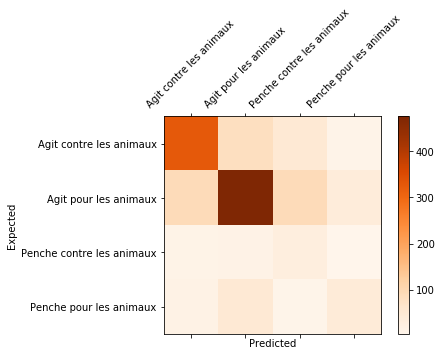

KNN
                           precision    recall  f1-score   support

  Agit contre les animaux       0.42      0.51      0.46      2511
    Agit pour les animaux       0.54      0.57      0.55      3399
Penche contre les animaux       0.28      0.02      0.03       290
  Penche pour les animaux       0.11      0.01      0.02       523

                 accuracy                           0.48      6723
                macro avg       0.34      0.28      0.27      6723
             weighted avg       0.45      0.48      0.45      6723

accuracy 0.4684014869888476
confusion matrix
                            Agit contre les animaux  Agit pour les animaux  \
Agit contre les animaux                        236                    229   
Agit pour les animaux                          299                    392   
Penche contre les animaux                       34                     27   
Penche pour les animaux                         51                     64   

                         

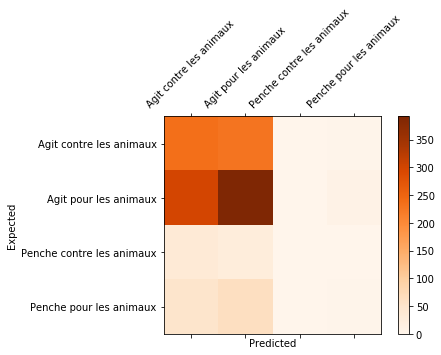

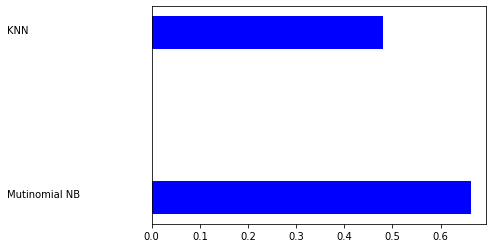

In [35]:
models = [
    ('Mutinomial NB', MultinomialNB()),
    ('KNN', KNeighborsClassifier()),
]

# Evaluation de chaque résultat
scores = []
names = []
scoring = 'accuracy'

# Validation croisée à 5 plis
kfold = model_selection.KFold(n_splits=5, shuffle=True)
for name, model in models:
    names.append(name)
    print(name)
    model_pipeline = make_pipeline(preprocess_pipeline,model)
    y_pred = model_selection.cross_val_predict(model_pipeline, X, y, 
                                               cv=kfold, n_jobs=2)
    print(classification_report(y, y_pred))
    acc = metrics.accuracy_score(y, y_pred)
    scores.append(acc)
    model_pipeline.fit(X_train, y_train)
    all_predictions = model_pipeline.predict(X_test)
    
    # all_predictions : classes prédites par l'algorithme d'apprentissage pour les données de test
    print('accuracy', accuracy_score(y_test, all_predictions))
    
    # Liste des labels (classes) se trouvant dans les données de test
    labels = np.unique(y_test)
    
    # Matrice de confusion
    cm =  confusion_matrix(y_test, all_predictions, labels=labels)
    
    # Matrice de confusion sous forme de DataFrame
    confusion_df = pd.DataFrame(cm, index=labels, columns=labels)
    print('confusion matrix\n', confusion_df)
    print('(row=expected, col=predicted)')
    labels = np.unique(y_test)
    cm = confusion_matrix(y_test, all_predictions, labels) 
    fig = plt.figure() 
    ax = fig.add_subplot(111) 
    cax = ax.matshow(cm, interpolation='nearest', cmap=plt.cm.Oranges) 
    fig.colorbar(cax) 
    tick_marks = np.arange(len(labels))
    labels_for_fig = [l for l in labels]
    plt.xticks(tick_marks, labels_for_fig, rotation=45)
    plt.yticks(tick_marks, labels_for_fig) 
    plt.xlabel('Predicted') 
    plt.ylabel('Expected') 
    plt.show()
    
# Représentation graphique
indices = np.arange(len(scores))
fig = plt.figure()
plt.barh(indices, scores, .2, label="score", color='b')
plt.yticks(())
for i, c in zip(indices, names):
    plt.text(-.3, i, c)
plt.show()

## Chaîne de prétraitement globale sans les traits concernant les statistiques

In [30]:
union = FeatureUnion(transformer_list = [
        ("titre_feature", titre_pipeline),
        ("description_feature", description_pipeline),
    ])

preprocess_pipeline = make_pipeline(
    union
)

preprocess_pipeline.fit(X_train)

Pipeline(memory=None,
         steps=[('featureunion',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('titre_feature',
                                                 Pipeline(memory=None,
                                                          steps=[('singlecolumnselector',
                                                                  SingleColumnSelector(key='titre')),
                                                                 ('countvectorizer',
                                                                  CountVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.int64'>,
                                                                             

## Application de la pipeline pour transformer les 5 premières instances de X_test

In [31]:
res = preprocess_pipeline.transform(X_test.head())
print("Input")
print(X_test.head())
print("Output")

all_features = pd.DataFrame(res.toarray(), 
                            columns=description_pipeline.named_steps['tfidfvectorizer'].get_feature_names()
                            + titre_pipeline.named_steps['countvectorizer'].get_feature_names()
                           )
all_features.set_index(X_test.head().index, inplace=True)
all_features.replace(0, np.nan).dropna(axis=1, how='all').fillna(0)

Input
                                                  titre  \
3379  Le Conseil départemental de la Vendée propose ...   
1239  La ville de Saint-Michel-sur-Orge refuse les c...   
656   Européennes 2019 : DLF veut systématiser la vi...   
2296  François Fillon veut simplifier le permis de c...   
608   2 députés demandent au gouvernement de s'oppos...   

                                            description  
3379   Dans le cadre de la Nuit Européenne des Muse...  
1239   Sensible au bien-être animal », la maire (LR)...  
656    5 Systématiser la vidéosurveillance et les in...  
2296   Simplifier et lever les contraintes administr...  
608    Question écrite de M. Anthony Cellier  député...  

Output


,',),1/2005,1000,19,2,2007,2017.,2018.,2020,...,protect,présidentiel,publiqu,que,refus,stérilis,une,ver,«,élevag
3379,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.084375,0.063601
1239,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.061432,0.185228
656,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2296,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
608,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,...,0.029935,0.018141,0.019809,0.038759,0.03625,0.025717,0.023913,0.029387,0.026882,0.000000


## Affichage du nombre de traits générés par chacune des chaines 

In [32]:
fnames_titre = titre_pipeline.named_steps['countvectorizer'].get_feature_names()
fnames_desc = description_pipeline.named_steps['tfidfvectorizer'].get_feature_names()
print('Nombres de traits extraits à partir de la colonne titre :', len(fnames_titre))
print('Nombres de traits extraits à partir de la colonne description :', len(fnames_desc))

Nombres de traits extraits à partir de la colonne titre : 204
Nombres de traits extraits à partir de la colonne description : 2275


## Comparaison des modèles

Mutinomial NB
                           precision    recall  f1-score   support

  Agit contre les animaux       0.78      0.80      0.79      2511
    Agit pour les animaux       0.79      0.83      0.81      3399
Penche contre les animaux       0.56      0.53      0.54       290
  Penche pour les animaux       0.52      0.30      0.38       523

                 accuracy                           0.76      6723
                macro avg       0.66      0.61      0.63      6723
             weighted avg       0.75      0.76      0.76      6723

accuracy 0.7620817843866171
confusion matrix
                            Agit contre les animaux  Agit pour les animaux  \
Agit contre les animaux                        398                     71   
Agit pour les animaux                           84                    568   
Penche contre les animaux                        8                     17   
Penche pour les animaux                         15                     76   

               

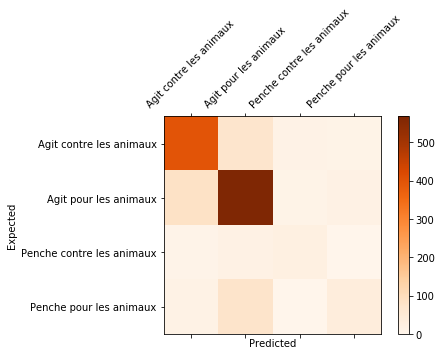

KNN
                           precision    recall  f1-score   support

  Agit contre les animaux       0.66      0.74      0.70      2511
    Agit pour les animaux       0.72      0.77      0.75      3399
Penche contre les animaux       0.95      0.33      0.49       290
  Penche pour les animaux       0.72      0.23      0.35       523

                 accuracy                           0.70      6723
                macro avg       0.76      0.52      0.57      6723
             weighted avg       0.71      0.70      0.69      6723

accuracy 0.7063197026022305
confusion matrix
                            Agit contre les animaux  Agit pour les animaux  \
Agit contre les animaux                        380                    110   
Agit pour les animaux                          147                    527   
Penche contre les animaux                       17                     18   
Penche pour les animaux                         30                     67   

                         

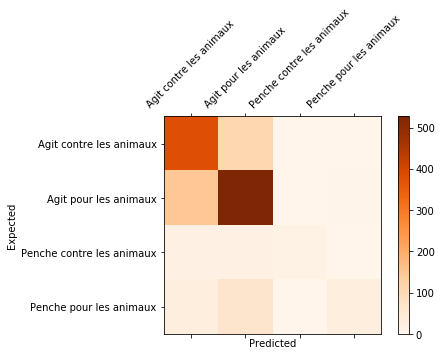

SVM
                           precision    recall  f1-score   support

  Agit contre les animaux       0.82      0.87      0.85      2511
    Agit pour les animaux       0.83      0.88      0.85      3399
Penche contre les animaux       0.79      0.58      0.67       290
  Penche pour les animaux       0.69      0.29      0.41       523

                 accuracy                           0.82      6723
                macro avg       0.78      0.66      0.69      6723
             weighted avg       0.81      0.82      0.81      6723

accuracy 0.8052044609665427
confusion matrix
                            Agit contre les animaux  Agit pour les animaux  \
Agit contre les animaux                        417                     66   
Agit pour les animaux                           62                    610   
Penche contre les animaux                       16                     11   
Penche pour les animaux                         15                     75   

                         

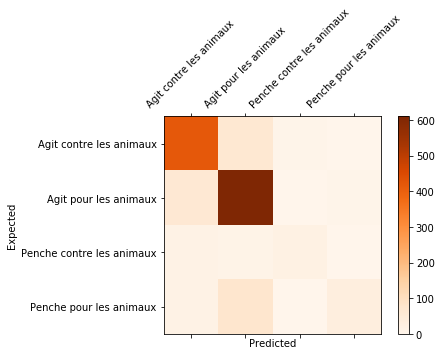

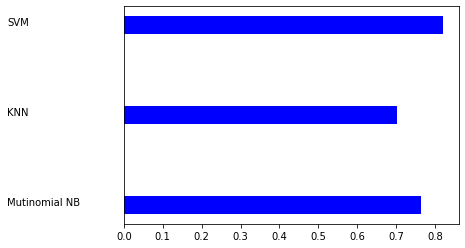

In [33]:
models = [
    ('Mutinomial NB', MultinomialNB()),
    ('KNN', KNeighborsClassifier()),
    ('SVM', svm.SVC(kernel='linear'))
]

# Evaluation de chaque résultat
scores = []
names = []
scoring = 'accuracy'

# Validation croisée à 5 plis
kfold = model_selection.KFold(n_splits=5, shuffle=True)
for name, model in models:
    names.append(name)
    print(name)
    model_pipeline = make_pipeline(preprocess_pipeline,model)
    y_pred = model_selection.cross_val_predict(model_pipeline, X, y, 
                                               cv=kfold, n_jobs=2)
    print(classification_report(y, y_pred))
    acc = metrics.accuracy_score(y, y_pred)
    scores.append(acc)
    model_pipeline.fit(X_train, y_train)
    all_predictions = model_pipeline.predict(X_test)
    
    # all_predictions : classes prédites par l'algorithme d'apprentissage pour les données de test
    print('accuracy', accuracy_score(y_test, all_predictions))
    
    # Liste des labels (classes) se trouvant dans les données de test
    labels = np.unique(y_test)
    
    # Matrice de confusion
    cm =  confusion_matrix(y_test, all_predictions, labels=labels)
    
    # Matrice de confusion sous forme de DataFrame
    confusion_df = pd.DataFrame(cm, index=labels, columns=labels)
    print('confusion matrix\n', confusion_df)
    print('(row=expected, col=predicted)')
    labels = np.unique(y_test)
    cm = confusion_matrix(y_test, all_predictions, labels) 
    fig = plt.figure() 
    ax = fig.add_subplot(111) 
    cax = ax.matshow(cm, interpolation='nearest', cmap=plt.cm.Oranges) 
    fig.colorbar(cax) 
    tick_marks = np.arange(len(labels))
    labels_for_fig = [l for l in labels]
    plt.xticks(tick_marks, labels_for_fig, rotation=45)
    plt.yticks(tick_marks, labels_for_fig) 
    plt.xlabel('Predicted') 
    plt.ylabel('Expected') 
    plt.show()
    
# Représentation graphique
indices = np.arange(len(scores))
fig = plt.figure()
plt.barh(indices, scores, .2, label="score", color='b')
plt.yticks(())
for i, c in zip(indices, names):
    plt.text(-.3, i, c)
plt.show()